# Exploratory analysis and preprocessing

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow
import time
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading the dataset

In [ ]:
nRowsRead = None # specify 'None' if want to read whole file
df1 = pd.read_csv('/content/drive/MyDrive/ProgettoAI/dataset/Food Ingredients and Recipe Dataset with Image Name Mapping.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Food Ingredients and Recipe Dataset with Image Name Mapping.csv'
nRows, nCols = df1.shape
print(f'There are {nRows} rows and {nCols} columns')

There are 13501 rows and 6 columns


In [ ]:
df1.head(5)

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [ ]:
# remove columns that hold useless information
df1.drop(['Unnamed: 0', 'Instructions'], axis=1, inplace=True)

In [ ]:
df1.head(5)

,Title,Ingredients,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


##Check NaN values

In [ ]:
# look for NaN values in column 'Title'
print(f"There is a total of {df1['Title'].isna().sum(axis=0)} NaN values in column 'Title'")

There is a total of 5 NaN values in column 'Title'


In [ ]:
# look for NaN values in column 'Ingredients'
print(f"There is a total of {df1['Ingredients'].isna().sum(axis=0)} NaN values in column 'Ingredients'")

There is a total of 0 NaN values in column 'Ingredients'


There are NaN values in column `Title`; we need to remove the corresponding rows of the data frame.

In [ ]:
nan_indexes = np.where(df1['Title'].isna())[0].tolist()
df1.drop(nan_indexes, axis=0, inplace=True)

In [ ]:
# check if there are NaN values left ('True' = 'no NaN values left')
df1['Title'].isna().sum(axis=0) == 0

True

In [ ]:
# check if there are any empty ingredients lists; in that case, remove them
empty_rows = []

for current_row in range(nRows):
  if current_row not in nan_indexes:
    if df1['Ingredients'][current_row] == '[]':
      empty_rows.append(current_row)

print(f"There are {len(empty_rows)} empty rows in column 'Ingredients'")

There are 7 empty rows in column 'Ingredients'


In [ ]:
df1.drop(empty_rows, axis=0, inplace=True)
invalid_indexes = empty_rows + nan_indexes

print(f"A total of {len(invalid_indexes)} rows have been removed from the original dataset")
print(f'There are now {df1.shape[0]} rows in the cleaned dataset')

A total of 12 rows have been removed from the original dataset
There are now 13489 rows in the cleaned dataset


##Check Dataset-Image Correspondence

In [ ]:
# Path to the directory that contains the images
food_images_path = '/content/drive/MyDrive/ProgettoAI/dataset/Food Images'

# Create a new directory where to put the useless images
useless_images_path = '/content/drive/MyDrive/ProgettoAI/dataset/Useless Images'
if not os.path.exists(useless_images_path):
  os.mkdir(useless_images_path)

images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13582 images in the directory


We have 13582 images in the directory and 13489 rows in the dataset, so it means we have to remove the images that don't have a correspondent row in the dataset.

In [ ]:
images_count = 0

for filename in os.listdir(food_images_path):
  # Remove '.jpg' from the filename, since in the column 'Image_Name' of the dataset there is only the name of the image without the extension
  filename_without_extension = filename[:-4]
  if filename_without_extension not in df1['Image_Name'].unique():
    images_count += 1
    image_path = food_images_path + '/' + filename
    if os.path.exists(image_path):
      shutil.move(image_path, useless_images_path)

print(f'Removed {images_count} images')

Removed 123 images


In [ ]:
images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13459 images in the directory


In [ ]:
print(f'There are {df1.shape[0]} rows and {df1.shape[1]} columns')

There are 13489 rows and 4 columns


Now we have 13459 images in the directory and 13489 rows in the dataset, so it means we have to remove the rows in the dataset that don't have a correspondent image in the folder.

In [ ]:
rows_count = 0
rows_to_delete = []

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    image_name = df1['Image_Name'][current_row]
    image_name += '.jpg'
    image_path = food_images_path + '/' + image_name
    if not os.path.exists(image_path):
      rows_to_delete.append(current_row)
      rows_count += 1

df1.drop(rows_to_delete, axis=0, inplace=True)
invalid_indexes += rows_to_delete
print(f'Removed {rows_count} rows')

Removed 30 rows


In [ ]:
print(f'There are {df1.shape[0]} rows and {df1.shape[1]} columns')

images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13459 rows and 4 columns
There are 13459 images in the directory


Now we have 13459 rows in the dataset and 13459 images in the directory, so it means we have a perfect correspondence.

In [ ]:
# There is a corrupted image, so we delete this image and the corresonding row in the dataset
corrupted_image_path = '/content/drive/MyDrive/ProgettoAI/dataset/Food Images/pan-seared-salmon-on-baby-arugula-242445.jpg'

if os.path.exists(corrupted_image_path):
  shutil.move(corrupted_image_path, useless_images_path)

df1.drop(df1.loc[df1['Image_Name']=='pan-seared-salmon-on-baby-arugula-242445'].index, inplace=True)
invalid_indexes += [9894]

In [ ]:
print(f'There are {df1.shape[0]} rows and {df1.shape[1]} columns')

images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13458 rows and 4 columns
There are 13458 images in the directory


Now we have 13458 rows in the dataset and 13458 images in the directory, so it means we have a perfect correspondence.

##'Ingredients' VS 'Cleaned_Ingredients'

In [ ]:
# check for differences between 'Ingredients' and 'Cleaned_Ingredients'
unequal_strings = 0
stop_print = 5
print_counter = 0

for current_row in range(nRows) :
  if current_row not in invalid_indexes:
    if(df1['Ingredients'][current_row] != df1['Cleaned_Ingredients'][current_row]):
      unequal_strings += 1
      if print_counter < stop_print:
        print(f"Row: {current_row}\ndf1['Ingredients'][row] : \n {df1['Ingredients'][current_row]}")
        print(f"df1['Cleaned_Ingredients'][row] : \n {df1['Cleaned_Ingredients'][current_row]}\n")
        print_counter += 1

Row: 0
df1['Ingredients'][row] : 
 ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']
df1['Cleaned_Ingredients'][row] : 
 ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (abo

In [ ]:
print(f"Number of unequal strings in columns 'Ingredients' and 'Cleaned_Ingredients' : {unequal_strings}")

Number of unequal strings in columns 'Ingredients' and 'Cleaned_Ingredients' : 3814


From direct observation, the column '**Cleaned_Ingredients**' does not seem to make any sense; it contains the same information of '**Ingredients**' but some *strings are splitted without any logical reason*.

`Example:`

'**Ingredients**': 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
`[..., '1 1/2 tablespoons unsalted butter, cut into bits', ...]`

'**Cleaned_Ingredients**': 
`[..., '1 1/2 tablespoons unsalted butter', 'cut into bits', ...]`

In [ ]:
# remove 'Cleaned_Ingredients' column
df1.drop(['Cleaned_Ingredients'], axis=1, inplace=True)

##Remove unwanted characters

Check for unwanted characters in the strings that make up the ingredients list.

In [ ]:
print(f"df1['Ingredients'][0] : {df1['Ingredients'][0]}")

df1['Ingredients'][0] : ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']


In [ ]:
# set strings to lowercase for columns "Ingredients" and "Title"
for current_row in range(nRows) :
  if current_row not in invalid_indexes:   
    df1['Ingredients'][current_row] = df1['Ingredients'][current_row].lower()
    df1['Title'][current_row] = df1['Title'][current_row].lower()

The following characters commonly appear in the ingredients list, e.g. given the popolarity of the *Jalapeño pepper* as cooking ingredient, or *Purée* as recipe, or *Crème Frïeche* etc...

These need to be specified manually since they occupy uncontinuous portions of the ASCII table.

In [ ]:
characters_to_keep = []
characters_to_keep.append(ord(' '))
characters_to_keep.append(ord('á'))
characters_to_keep.append(ord('à'))
characters_to_keep.append(ord('â'))
characters_to_keep.append(ord('ä'))
characters_to_keep.append(ord('ã'))
characters_to_keep.append(ord('å'))
characters_to_keep.append(ord('ç'))
characters_to_keep.append(ord('é'))
characters_to_keep.append(ord('è'))
characters_to_keep.append(ord('ê'))
characters_to_keep.append(ord('ë'))
characters_to_keep.append(ord('í'))
characters_to_keep.append(ord('ì'))
characters_to_keep.append(ord('î'))
characters_to_keep.append(ord('ï'))
characters_to_keep.append(ord('ñ'))
characters_to_keep.append(ord('ó'))
characters_to_keep.append(ord('ò'))
characters_to_keep.append(ord('ô'))
characters_to_keep.append(ord('ö'))
characters_to_keep.append(ord('õ'))
characters_to_keep.append(ord('ù'))
characters_to_keep.append(ord('ú'))
characters_to_keep.append(ord('û'))
characters_to_keep.append(ord('ü'))

In [ ]:
# build a set of the unwanted characters (like numbers, commas, symbols etc...)
unwanted_characters = set()
unwanted_characters.add("'s") # manually add the possessive "'s" to the set

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    for char in df1['Ingredients'][current_row] :
      char_code = ord(char)
      if ((char_code < 97 or char_code > 122) and char_code not in characters_to_keep) :
        unwanted_characters.add(char)

print(unwanted_characters)

{'®', '>', '7', '¼', '5', '⁄', '{', '-', '2', ')', '[', '4', '⅛', ';', '″', '"', ':', '½', 'ﬁ', '“', '_', '%', '—', '.', '3', '/', '’', '+', 'ź', "'", '⅜', '‑', '̀', '–', '*', '°', '¿', '⅞', '”', '!', '=', '@', ']', '¾', '&', '|', '6', '⅓', '1', 'ﬂ', '•', '(', '⅔', '‚', '0', "'s", '9', '<', '8', '�', ',', '\\', '́', '#', 'ﬀ', '}', '$', '™', '̂', 'ō', '‐', '×'}


In [ ]:
print(f"Number of unwanted characters: {len(unwanted_characters)}")

Number of unwanted characters: 72


-The set "**unwanted_characters**" can now be used to remove unwanted characters from the list of ingredients. Something like: 

`'1 (3½–4-lb.) whole chicken' → ' lb whole chicken'`

*(note that the first character in the resulting string is a blank space, and 'lb' which stands for 'punds' is still there, although we do not want to keep that kind of information).*


-This is going to be the first step to obtain a "clean" list of ingredients. The next will be to **remove all measures**, like: 

`'1 cup evaporated milk' → ' cup evaporated milk' → 'evaporated milk'`


In [ ]:
# create a "cleaned" copy of the df
df_cleaned = df1.copy()

In [ ]:
# remove unwanted characters
for current_row in range(nRows):
  if current_row not in invalid_indexes:
    for char in df_cleaned['Ingredients'][current_row] :
      if char in unwanted_characters :
        df_cleaned['Ingredients'][current_row] = df_cleaned['Ingredients'][current_row].replace(char, ' ')

In [ ]:
print(f"First row ORIGINAL:\n{df1['Ingredients'][0]}\n")
print(f"First row CLEANED:\n{df_cleaned['Ingredients'][0]}")

First row ORIGINAL:
['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 tbsp. finely chopped sage', '1 tbsp. finely chopped rosemary', '6 tbsp. unsalted butter, melted, plus 3 tbsp. room temperature', '¼ tsp. ground allspice', 'pinch of crushed red pepper flakes', 'freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1" pieces (about 2½ cups)', '2 medium apples (such as gala or pink lady; about 14 oz. total), cored, cut into 1" pieces', '2 tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 tbsp. apple cider vinegar', '1 tbsp. white miso', '¼ cup all-purpose flour', '2 tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'kosher salt, freshly ground pepper']

First row CLEANED:
          lb   whole chicken       tsp  kosher salt  divided  plus more      small acorn squash  about   lb  total       tbsp  fine

Now check column `Title` for unwanted characters.

In [ ]:
n_uc = 0 # number of unwanted characters

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    for char in df_cleaned['Title'][current_row] :
      if char in unwanted_characters :
        n_uc += 1

print(f"There are {n_uc} unwanted symbols in column 'Titles'")

There are 7220 unwanted symbols in column 'Titles'


Do the same as for column `Ingredients`.

In [ ]:
# remove unwanted characters
for current_row in range(nRows):
  if current_row not in invalid_indexes:
    for char in df_cleaned['Title'][current_row] :
      if char in unwanted_characters :
        df_cleaned['Title'][current_row] = df_cleaned['Title'][current_row].replace(char, ' ')

In [ ]:
df_cleaned.head(5)

,Title,Ingredients,Image_Name
0,miso butter roast chicken with acorn squash pa...,lb whole chicken tsp kosher...,miso-butter-roast-chicken-acorn-squash-panzanella
1,crispy salt and pepper potatoes,large egg whites pound new potatoes ...,crispy-salt-and-pepper-potatoes-dan-kluger
2,thanksgiving mac and cheese,cup evaporated milk cup whole milk ...,thanksgiving-mac-and-cheese-erick-williams
3,italian sausage and bread stuffing,to pound round italian loaf cut in...,italian-sausage-and-bread-stuffing-240559
4,newton s law,teaspoon dark brown sugar teaspoon ho...,newtons-law-apple-bourbon-cocktail


##Remove unwanted words

We need to specify which words need to be dropped from the lists of ingradients.

In [ ]:
unwanted_words = [
  " lb ",
  " tsp ",
  " tbsp ",
  " tablespoons ",
  " tablespoon ",
  " teaspoons ",
  " teaspoon ",
  " pounds ",
  " pound ",
  " small ",
  " big ",
  " and ",
  " about ",
  " plus ",
  " more ", 
  " divided ",
  " sliced ",
  " chopped ",
  " fresh ",
  " ground ",
  " finely ",
  " melted ",
  " frozen ",
  " room ",
  " temperature ",
  " into ",
  " pieces ",
  " piece ",
  " of ",
  " cups ",
  " cup ",
  " medium ",
  " with ",
  " total ",
  " ly ",
  " pinch ",
  " crushed ",
  " torn ",
  " such ",
  " as ",
  " or ",
  " oz ",
  " ounce ",
  " ounces ",
  " sturdy ",
  " goodquality ",
  " good quality ",
  " good ",
  " quality ",
  " torn ",
  " in ",
  " cored ",
  " gala ",
  " pink lady ",
  " all ",
  " purpose ",
  " freshly ",
  " do ",
  " not ",
  " thaw ",
  " halved ",
  " through ",
  " thinly ",
  " boneless ",
  " softened ",
  " mixed ",
  " freshwater ",
  " preferably ",
  " italian ",
  " grechetto ",
  " vermentino ",
  " trebbiano ",
  " well ",
  " making ",
  " equipment ",
  " can ",
  " be ",
  " ordered ",
  " from ",
  " latienda ",
  " com ",
  " dash ",
  " cut ",
  " store ",
  " bought ",
  " homemade ",
  " self ",
  " rising ",
  " store ",
  " parts ",
  " part ",
  " only ",
  " optional ",
  " see ",
  " note ",
  " nonstick ",
  " inches ",
  " inch ",
  " large ",
  " firmly ",
  " packed ",
  " cooled ",
  " flat ",
  " regular ",
  " coarsely ",
  " coarse ",
  " prepared ",
  " grated ",
  " thin ",
  " slices ",
  " slice ",
  " long ",
  " very ",
  " thick ",
  " rounds ",
  " round ",
  " stalks ",
  " stalk ",
  " ingredient ",
  " info ",
  " cracked ",
  " shelled ",
  " low salt ",
  " low ",
  " tender ",
  " stems ",
  " stem ",
  " sticks ",
  " stick ",
  " fl ",
  " reduced sodium ",
  " reduced ",
  " bits ",
  " bit ",
  " heavy ",
  " if ",
  " desired ",
  " granulated ",
  " on ",
  " stirred ",
  " trimmed ",
  " diagonally ",
  " additional ",
  " for ",
  " end ",
  " whole ",
  " jellied ",
  " garnish ",
  " taste ",
  " to ",
  " packages ",
  " hot ",
  " cold ",
  " warm ",
  " tiepid ",
  " split ",
  " lengthwise ",
  " edible ",
  " fronds ",
  " i ",
  " like ",
  " a ",
  " mixture ",
  " bunches ",
  " bunch ",
  " is ",
  " my ",
  " preference ",
  " style ",
  " warmed ",
  " the ",
  " oven ",
  " an ",
  " rinsed ",
  " minced ",
  " ml ",
  " cl ",
  " mg ",
  " milligrams ",
  " milligram ",
  " grams ",
  " gram ",
  " wooden ",
  " spoons ",
  " spoon ",
  " knife ",
  " knives ",
  " fork ",
  " also ",
  " known ",
  " pint ",
  " cubes ",
  " pullman ",
  " discarded ",
  " discard ",
  " bottled ",
  " roasted ",
  " rustic ",
  " horizontally ",
  " vertically ",
  " horizontal ",
  " vertical ",
  " demi ",
  " casserole ",
  " skewers ",
  " skewer ",
  " package ",
  " crosswise ",
  " wide ",
  " button ",
  " stemmed ",
  " quartered ",
  " beaten ",
  " blend ",
  " skewers ",
  " maker ",
  " make ",
  " boiler ",
  " boiled ",
  " boil ",
  " strips ",
  " strip ",
  " including ",
  " included ",
  " include ",
  " add ",
  " adding ",
  " quart ",
  " shallow ",
  " flameproof ",
  " dish ",
  " deep ",
  " glass ",
  " glasses ",
  " raw ",
  " standard ",
  " pitted ", 
  " wedges ",
  " muffin pan ",
  " mortar ",
  " pestle ",
  " tough ", 
  " outer ",
  " layers ",
  " removed ",
  " remove ",
  " shaved ",
  " shave ",
  " crumbled ",
  " thinned ",
  " thawed ",
  " patted ",
  " smashed ",
  " smash ",
  " unpeeled ",
  " unpeel ",
  " peeled ",
  " peel ",
  " pans ",
  " pan ",
  " one ",
  " two ",
  " three ",
  " four ",
  " five ",
  " six ",
  " seven ",
  " eight ",
  " nine ",
  " ten ",
  " kisses ",
  " mini ",
  " powdered ",
  " bag ",
  " cans ",
  " can ",
  " each ",
  " tube ",
  " bottles ",
  " bottle ",
  " husked ",
  " husk ",
  " purchased ",
  " purchase ",
  " kugelhopf ",
  " confectioners ",
  " confectioner ",
  " chilled ",
  " stand ",
  " mixers ",
  " mixer ",
  " fitted ",
  " fit ",
  " paddles ",
  " paddle ",
  " attachments ",
  " attachment ",
  " jars ",
  " jar ",
  " generous ",
  " lightly ",
  " completely ",
  " short ",
  " accompaniment ",
  " electric ",
  " grinders ",
  " grinder ",
  " delicious ",
  " shucked ",
  " prince edward island ",
  " theirs ",
  " their ",
  " skinless ",
  " skinned ",
  " slathering ",
  " left ",
  " leave ",
  " seasoned "
  " season ",
  " light ",
  " sprigs ",
  " sprig ",
  " triples ",
  " triple ",
  " doubles ",
  " double ",
  " uncooked ",
  " cooked ",
  " cook ",
  " unseasoned ",
  " balls ",
  " ball ",
  " drained ",
  " drain ",
  " flaky ",
  " surfaces ",
  " surface ",
  " toasted ",
  " toast ",
  " others ",
  " other ",
  " fruity ",
  " sodium ",
  " handful ",
  " diced ",
  " dices ",
  " dice ",
  " handful ",
  " servings ",
  " serving ",
  " serve ",
  " seeded ",
  " seedless ",
  " skin ",
  " shredded ",
  " carcass ",
  " reserved ",
  " stocks ",
  " stock ",
  " head ",
  " sheet ",
  " puff ",
  " pastry ",
  " nonfat ",
  " separated ",
  " separates ",
  " separate ",
  " wild ",
  " soaked ",
  " soak ",
  " hours ",
  " hour ",
  " minutes ",
  " minute ",
  " seconds ",
  " second ",
  " old fashioned ",
  " old ",
  " fashioned ",
  " spice mill ",
  " peeler ",
  " milliliters ",
  " milliliter ",
  " higher ",
  " high ",
  " noilly prat ",
  " scooped ",
  " bowls ",
  " bowl ",
  " steamed ",
  " steam ",
  " boxes ",
  " box ",
  " squares ",
  " square ",
  " natural ",
  " unblanched ",
  " available ", 
  " at ",
  " some ",
  " supermarkets ",
  " supermarket ",
  " natural ",
  " foods ",
  " food ",
  " stores ",
  " store ",
  " middle ",
  " eastern ",
  " markets ",
  " pliers ", 
  " needlenose ", 
  " needles ",
  " needle ",
  " metal ", 
  " kitchen ",
  " strings ",
  " string ", 
  " metal ",
  " racks ",
  " rack ",
  " instant ",
  " read ",
  " thermometers ",
  " thermometer ",
  " scant ",
  " cm ",
  " spreads ",
  " spread ",
  " uses ",
  " use ",
  " plates ",
  " plate ",
  " gallons ",
  " gallon ",
  " cardboard ",
  " carton ",
  " top ",
  " spout ",
  " off ",
  " scrubbed ",
  " scrub ",
  " assorted ",
  " you ",
  " goes ",
  " go ",
  " vegetarian ",
  " by ",
  " leaving ",
  " out ",
  " goosing ",
  " up ",
  " numbers ",
  " number ",
  " no ",
  " needs ",
  " need ",
  " peel ",
  " bitesize ",
  " chunks ",
  " washed ",
  " wash ",
  " fine ",
  " any ",
  " sized ",
  " sizes ",
  " that ",
  " fancy ",
  " markets ",
  " internet ",
  " throw ",
  " no ",
  " intense ",
  " unwanted ",
  " wanted ",
  " want ",
  " almost ",
  " half ",
  " halves ",
  " sides ",
  " side ",
  " artisanal ",
  " greasing ",
  " foils ",
  " foil ",
  " bodies ",
  " body ",
  " tentacles ",
  " tentacle ",
  " maldon ",
  " grade ",
  " grades ",
  " degrees ",
  " degree ",
  " snapper ",
  " parchment ",
  " papers ",
  " paper ",
  " silvered ",
  " liquid ",
  " full "
]

In [ ]:
print(f"Number of unwanted words: {len(unwanted_words)}")

Number of unwanted words: 500


In [ ]:
# check if a specific word is already in the list
word = "four" # word to be checked
" "+word+" " in unwanted_words

True

In [ ]:
df_cleaned_final = df_cleaned.copy()

In [ ]:
# remove unwanted words
for current_row in range(nRows):
  if current_row not in invalid_indexes: 
    splitted_row = df_cleaned_final['Ingredients'][current_row].split()
    for word in splitted_row:
      if (" "+word+" " in unwanted_words or len(word) == 1): # remove also single characters, since they are not words
        df_cleaned_final['Ingredients'][current_row] = df_cleaned_final['Ingredients'][current_row].replace(" "+word+" ", ' ')

In [ ]:
# remove blank spaces
for current_row in range(nRows) : 
  if current_row not in invalid_indexes: 
    df_cleaned_final['Ingredients'][current_row] = ' '.join(df_cleaned_final['Ingredients'][current_row].split())

In [ ]:
# check first row
print(f"First row CLEANED FINAL:\n{df_cleaned_final['Ingredients'][0]}")

First row CLEANED FINAL:
chicken kosher salt acorn squash sage rosemary unsalted butter allspice red pepper flakes black pepper loaf white bread apples pink lady extra virgin olive oil red onion apple cider vinegar white miso flour unsalted butter dry white wine unsalted chicken broth white miso kosher salt pepper


The list of ingredients in the first row of the dataset now looks pretty good 👍🏼

##Check for empty ingredients lists

In [ ]:
# check if there are any empty ingredients lists; in that case, remove them
empty_rows = []

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    if len(df_cleaned_final['Ingredients'][current_row]) == 0:
      empty_rows.append(current_row)  

print(f"There are {len(empty_rows)} empty rows in column 'Ingredients'")

There are 1 empty rows in column 'Ingredients'


In [ ]:
# the following row will be removed
df1['Ingredients'][empty_rows[0]]

"['n/a n/a']"

In [ ]:
df1['Image_Name'][empty_rows[0]]

'to-quick-soak-dried-beans-15153'

In [ ]:
image_to_delete_path = '/content/drive/MyDrive/ProgettoAI/dataset/Food Images/to-quick-soak-dried-beans-15153.jpg'

if os.path.exists(image_to_delete_path):
  shutil.move(image_to_delete_path, useless_images_path)

df_cleaned_final.drop(empty_rows, axis=0, inplace=True)
invalid_indexes += empty_rows

print(f"A total of {len(invalid_indexes)} rows have been removed from the original dataset")
print(f'There are now {df_cleaned_final.shape[0]} rows in the cleaned dataset')

A total of 44 rows have been removed from the original dataset
There are now 13457 rows in the cleaned dataset


In [ ]:
print(f'There are {df_cleaned_final.shape[0]} rows and {df_cleaned_final.shape[1]} columns')

images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13457 rows and 3 columns
There are 13457 images in the directory


Now we have 13457 rows in the dataset and 13457 images in the directory, so it means we have a perfect correspondence.

# Document Embedding with Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
ingredients_lists = []

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    ingredients_lists.append(df_cleaned_final['Ingredients'][current_row].split())

In [ ]:
len(ingredients_lists)

13457

In [ ]:
ingredients = [TaggedDocument(doc, [i]) for i, doc in enumerate(ingredients_lists)]

In [ ]:
np.shape(ingredients)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(13457, 2)

In [ ]:
# train the Doc2Vec model
model_ingredients = Doc2Vec(ingredients, vector_size=1024, window=3, min_count=2, workers=4, epochs = 30)

And now the same thing for the information in the `Title` column.

In [ ]:
titles_lists = []

for current_row in range(nRows):
  if current_row not in invalid_indexes:
    titles_lists.append(df_cleaned_final['Title'][current_row].split())

In [ ]:
len(titles_lists)

13457

In [ ]:
titles = [TaggedDocument(doc, [i]) for i, doc in enumerate(titles_lists)]

In [ ]:
np.shape(titles)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(13457, 2)

In [ ]:
# train the Doc2Vec model
model_titles = Doc2Vec(titles, vector_size=1024, window=3, min_count=2, workers=4, epochs = 30)

In [ ]:
# save 'model_ingredients' to memory
path = '/content/drive/MyDrive/ProgettoAI/Doc2Vec_models/model_ingredients'
model_ingredients.save(path)
# save 'model_titles' to memory
path = '/content/drive/MyDrive/ProgettoAI/Doc2Vec_models/model_titles'
model_titles.save(path)

In [ ]:
# # load models from file
# path = '/content/drive/MyDrive/ProgettoAI/Doc2Vec_models/model_ingredients'
# model_ingredients = Doc2Vec.load(path)
# path = '/content/drive/MyDrive/ProgettoAI/Doc2Vec_models/model_titles'
# model_titles = Doc2Vec.load(path)

#Image Embedding with VGG16

We use VGG16 pre-trained on ImageNet to extract the features of the food images.

In [ ]:
# VGG16 pre-trained on ImageNet
base_model = VGG16(weights = 'imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Cut at 'fc1' layer
cut_model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
cut_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# feature extraction
def extract_image_features():
  features_array = []

  for current_row in range(nRows):
    if current_row not in invalid_indexes:
      image_array = []
      image_name = df_cleaned_final['Image_Name'][current_row]
      image_path = food_images_path + '/' + image_name + '.jpg'
      img = image.load_img(image_path, target_size = (224, 224))
      img = image.img_to_array(img)
      img = preprocess_input(img)
      image_array.append(img)
      image_array = np.array(image_array)
      features = cut_model.predict(image_array)
      features_array.append(features)

  np.array(features_array) # current shape = (13457, 1, 4096)
  return np.reshape(features_array, (np.shape(features_array)[0], np.shape(features_array)[2])) # new shape = (13457, 4096)

# features_array = extract_image_features()

In [ ]:
# # save image embeddings (feature vectors) to Drive
# path_to_file = '/content/drive/MyDrive/ProgettoAI/image_embeddings/features-VGG16_FC1.npy'
# np.save(path_to_file, features_array)

In [ ]:
# load image embeddings from Drive
path_to_file = '/content/drive/MyDrive/ProgettoAI/image_embeddings/features-VGG16_FC1.npy'
loaded_features = np.load(path_to_file)

In [ ]:
print(f"The size of the features array is {np.shape(loaded_features)}")

The size of the features array is (13457, 4096)


#Multimodal Embedding

Concatenate the title embeddings, ingredients embeddings and images embeddings horizontally to obtain the final multimodal embeddings. 

In [ ]:
print(np.shape(model_titles.docvecs.vectors_docs))
print(np.shape(model_ingredients.docvecs.vectors_docs))
print(np.shape(loaded_features))

(13457, 1024)
(13457, 1024)
(13457, 4096)


In [ ]:
multimodal_embeddings = np.hstack((model_titles.docvecs.vectors_docs, model_ingredients.docvecs.vectors_docs, loaded_features))

In [ ]:
np.shape(multimodal_embeddings)

(13457, 6144)

In [ ]:
formatted_dataset = []
for current_row in range(nRows):
  if current_row not in invalid_indexes:
    row_data = df_cleaned_final['Title'][current_row] + '!' + \
               df_cleaned_final['Ingredients'][current_row] + '!' + \
               df_cleaned_final['Image_Name'][current_row]
    formatted_dataset.append(row_data)

In [ ]:
len(formatted_dataset)

13457

#Cosine Distance

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
def most_similar_existing_data(index):
  min_distance = 1000
  for i in range(len(multimodal_embeddings)):
    if i != index:
      distance = cosine(multimodal_embeddings[index], multimodal_embeddings[i])
      if distance < min_distance:
        min_distance = distance
        min_index = i
  return min_index, min_distance

In [ ]:
def most_similar_new_data(title, ingredients, image_path):
  # text embedding
  title_list = title.split()
  ingredients_list = ingredients.split()
  title_embedding = model_titles.infer_vector(title_list)
  ingredients_embedding = model_ingredients.infer_vector(ingredients_list)
  title_embedding = np.reshape(title_embedding, (1, np.shape(title_embedding)[0]))
  ingredients_embedding = np.reshape(ingredients_embedding, (1, np.shape(ingredients_embedding)[0]))
  # image embedding
  image_array = []
  img = image.load_img(image_path, target_size = (224, 224))
  img = image.img_to_array(img)
  img = preprocess_input(img)
  image_array.append(img)
  image_array = np.array(image_array)
  image_embedding = cut_model.predict(image_array)
  # multimodal embedding
  multimodal_embedding = np.hstack((title_embedding, ingredients_embedding, image_embedding))
  # get most similar embedding
  min_distance = 1000
  for i in range(len(multimodal_embeddings)):
    distance = cosine(multimodal_embedding, multimodal_embeddings[i])
    if distance < min_distance:
      min_distance = distance
      min_index = i
  return min_index, min_distance

# Testing the model

In [ ]:
def plot_existing_images(example_index, min_index):
  image_name = formatted_dataset[example_index].split('!')[-1]
  image_path = food_images_path + '/' + image_name + '.jpg'
  img = image.load_img(image_path, target_size = (224, 224))
  img = image.img_to_array(img)
  ax = plt.subplot(1, 2, 1)
  plt.imshow(img.astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  image_name = formatted_dataset[min_index].split('!')[-1]
  image_path = food_images_path + '/' + image_name + '.jpg'
  img = image.load_img(image_path, target_size = (224, 224))
  img = image.img_to_array(img)
  ax = plt.subplot(1, 2, 2)
  plt.imshow(img.astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [ ]:
def plot_new_images(image_path, min_index):
  img = image.load_img(image_path, target_size = (224, 224))
  img = image.img_to_array(img)
  ax = plt.subplot(1, 2, 1)
  plt.imshow(img.astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  image_name = formatted_dataset[min_index].split('!')[-1]
  image_path = food_images_path + '/' + image_name + '.jpg'
  img = image.load_img(image_path, target_size = (224, 224))
  img = image.img_to_array(img)
  ax = plt.subplot(1, 2, 2)
  plt.imshow(img.astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## Images and texts are both similar

Index of the minimum distance = 7952
And the minimum distance is: 0.45535892248153687

Given example: 
Title: neapolitan style pizza  pizza alla napoletana  
Ingredients: water envelope active dry yeast extra virgin olive oil needed flour needed kosher salt buffalo mozzarella san marzano tomatoes basil leaves dried sicilian oregano black pepper

Most similar recipe: 
Title: cherry tomato pizza margherita 
Ingredients: refrigerated pizza dough extra virgin olive oil cherry tomatoes garlic clove pressed fennel seeds plastic dried red pepper mozzarella water ovoline milk mozzarella basil leaves leaves



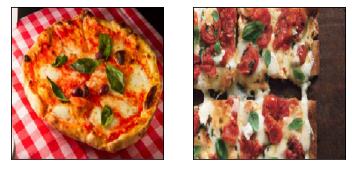

In [ ]:
# existing data
example_index = 6054
min_index, min_distance = most_similar_existing_data(example_index)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
result = formatted_dataset[example_index].split('!')
print(f"Given example: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_existing_images(example_index, min_index)

Index of the minimum distance = 12470
And the minimum distance is: 0.2971838116645813

Given example: 
Title: classic hamburger 
Ingredients: onion oil ketchup mayonnaise white vinegar ground beef ground pepper bread tomato lettuce

Most similar recipe: 
Title: the ultimate hamburger 
Ingredients: chuck sirloin salt kosher sea black pepper black pepper size onion sandwich bread butter size gorgeous luscious ripe red tomatoes boston lettuce leaves iceberg lettuce cheese sauce



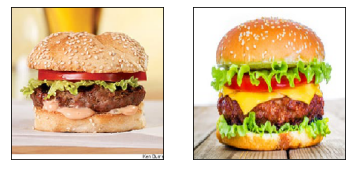

In [ ]:
# new data
_title = "classic hamburger"
_ingredients = "onion oil ketchup mayonnaise white vinegar ground beef ground pepper bread tomato lettuce"
image_path = "/content/drive/MyDrive/ProgettoAI/test_images/classic-hamburger.jpg"
min_index, min_distance = most_similar_new_data(_title, _ingredients, image_path)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
print(f"Given example: \nTitle: {_title} \nIngredients: {_ingredients}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_new_images(image_path, min_index)

## Images are similar but texts are not

Index of the minimum distance = 1443
And the minimum distance is: 0.37191861867904663

Given example: 
Title: green curry vinegar chicken 
Ingredients: shallots green beans peppadew peppers brine white wine vinegar extra virgin olive oil thai green curry paste chicken thighs drumsticks kosher salt

Most similar recipe: 
Title: parmesan bread pudding with broccoli rabe and pancetta 
Ingredients: olive oil garlic cloves red pepper flakes broccoli rabe rapini kosher salt black pepper eggs milk country white bread parmesan pancetta bacon



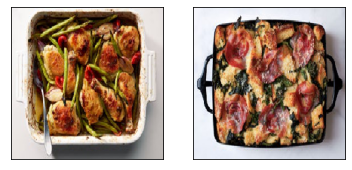

In [ ]:
# existing data
example_index = 327
min_index, min_distance = most_similar_existing_data(example_index)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
result = formatted_dataset[example_index].split('!')
print(f"Given example: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_existing_images(example_index, min_index)

Index of the minimum distance = 5935
And the minimum distance is: 0.38019728660583496

Given example: 
Title: lasagna stuffed shells 
Ingredients: beef black pepper olive oil onion tomato paste dried oregano tomato sauce jumbo pasta shells cloves garlic whole milk ricotta cheese mozzarella cheese spinach basil lemon parmesan cheese

Most similar recipe: 
Title:  simple is best  dressing 
Ingredients: unsalted butter baking day white bread yellow onions celery leaf parsley sage rosemary thyme kosher salt black pepper chicken broth vegetable broth eggs



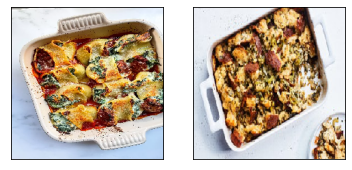

In [ ]:
# new data
_title = "lasagna stuffed shells"
_ingredients = "beef black pepper olive oil onion tomato paste dried oregano tomato sauce jumbo pasta shells cloves garlic whole milk ricotta cheese mozzarella cheese spinach basil lemon parmesan cheese"
image_path = "/content/drive/MyDrive/ProgettoAI/test_images/Lasagna-StuffedShells.jpg"
min_index, min_distance = most_similar_new_data(_title, _ingredients, image_path)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
print(f"Given example: \nTitle: {_title} \nIngredients: {_ingredients}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_new_images(image_path, min_index)

## Texts are similar but images are not

Index of the minimum distance = 4535
And the minimum distance is: 0.386188268661499

Given example: 
Title: shaved zucchini salad with parmesan pine nuts 
Ingredients: extra virgin olive oil lemon juice kosher salt black pepper dried red pepper zucchini basil pine nuts wedge parmesan cheese

Most similar recipe: 
Title: grilled zucchini and leeks with walnuts and herbs 
Ingredients: walnuts garlic clove lemon juice olive oil kosher salt black pepper leeks white pale green root attached zucchini leaf parsley leaves



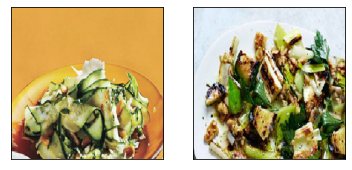

In [ ]:
# existing data
example_index = 7623
min_index, min_distance = most_similar_existing_data(example_index)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
result = formatted_dataset[example_index].split('!')
print(f"Given example: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_existing_images(example_index, min_index)

It seems that when the text is very similar, it is not possible to get images that are completely different, since same title + same ingredients means that we are looking at the same recipes, and these will hardly look different.



##Images and texts are not similar

Index of the minimum distance = 12075
And the minimum distance is: 0.39483779668807983

Given example: 
Title: tunisian vegetable salsa 
Ingredients: garlic cloves plum tomatoes onions red bell peppers poblano chile japanese eggplant extra virgin olive oil lemon juice kosher salt black pepper dark green poblano chiles are better specialty

Most similar recipe: 
Title: lamb chili with masa harina dumplings 
Ingredients: dried mild new mexico chiles water lamb shoulder black pepper salt lard vegetable oil onion garlic cloves turkish bay leaves california cumin dried oregano canned chipotle chiles adobo masa harina corn tortilla mix flour baking powder baking soda salt lard unsalted butter shaken buttermilk cilantro



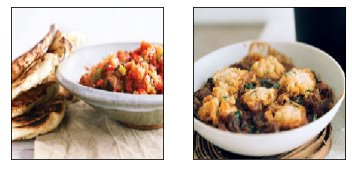

In [ ]:
# existing data
example_index = 7050
min_index, min_distance = most_similar_existing_data(example_index)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
result = formatted_dataset[example_index].split('!')
print(f"Given example: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_existing_images(example_index, min_index)

Index of the minimum distance = 10804
And the minimum distance is: 0.4703138470649719

Given example: 
Title: spaghetti with meatballs 
Ingredients: spaghetti ground beef bread crumbs parsley parmesan egg garlic cloves kosher salt red pepper virgin olive oil onion tomatoes bay ground black pepper

Most similar recipe: 
Title: grilled shrimp and scallions with southeast asian dipping sauces 
Ingredients: asian fish sauce lime juice sugar jalapeño chile rings soy sauce rice wine vinegar ginger cilantro coriander seeds colossal under per jumbo per shrimp tails intact deveined scallions white green vegetable oil kosher salt black pepper called nuoc mam nam pla asian asian section water



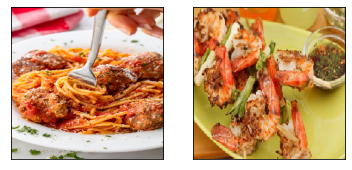

In [ ]:
# new data
_title = "spaghetti with meatballs"
_ingredients = "spaghetti ground beef bread crumbs parsley parmesan egg garlic cloves kosher salt red pepper virgin olive oil onion tomatoes bay ground black pepper"
image_path = "/content/drive/MyDrive/ProgettoAI/test_images/spaghetti-with-meatballs.jpg"
min_index, min_distance = most_similar_new_data(_title, _ingredients, image_path)
print(f"Index of the minimum distance = {min_index}")
print(f"And the minimum distance is: {min_distance}\n")
print(f"Given example: \nTitle: {_title} \nIngredients: {_ingredients}\n")
result = formatted_dataset[min_index].split('!')
print(f"Most similar recipe: \nTitle: {result[0]} \nIngredients: {result[1]}\n")
plot_new_images(image_path, min_index)

#Back to original images dataset

In [ ]:
# Script to move images from 'Useless Images' to 'Food Images' and to delete 'Useless Images' folder at the end of the execution
for filename in os.listdir(useless_images_path):
  image_path = useless_images_path + '/' + filename
  if os.path.exists(image_path):
    shutil.move(image_path, food_images_path)

if os.path.exists(useless_images_path):
  os.rmdir(useless_images_path)

In [ ]:
images_count = 0

# Iterate directory
for filename in os.listdir(food_images_path):
  images_count += 1

print(f'There are {images_count} images in the directory')

There are 13582 images in the directory
